In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import random 
import tensorflow as tf
from PIL import Image
from sklearn.preprocessing import OneHotEncoder 


DIRECTORY = 'skindata'
CATEGORIES = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

IMG_SIZE = 100

data = []
label = []
result = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        label = CATEGORIES.index(category)
        img = Image.open(img_path)
        img = img.resize((IMG_SIZE,IMG_SIZE))
        img = np.array(img)
        if(img.shape == (IMG_SIZE,IMG_SIZE,3)):
            data.append([np.array(img), label])

In [2]:
data[0][0].shape
random.shuffle(data)

In [3]:
X = []
y = []

for features, labels in data:
    X.append(features)
    y.append(labels)

X = np.array(X)
y = np.array(y)
X.shape

(5040, 100, 100, 3)

In [4]:
X_cont = []
for i in range (5040):
    X_cont.append(cv2.addWeighted(X[i], .75, np.zeros(img.shape, img.dtype), 0, 0))

X_count = np.array(X_cont)
X_count.shape
X_count = X_count/255

# 1.35 = 59
# 1.25 = 68
# 1.15 = 70
# 0.75 = 71
# 0.75 = 72.5 ..... 5 hidden layers
# 0.75 = 71.73 & 88 ..... 5 hidden layers
# Increase epochs and the hidden layer
# 0.70 = 63

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_cont, y, test_size = 0.2, stratify=y, random_state=1)
X_train = np.array(X_train)
X_train.shape

(4032, 100, 100, 3)

In [6]:
import tensorflow as tf
from keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras import datasets, layers, models
from keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization

cnn = models.Sequential()

cnn.add(layers.Conv2D(64,kernel_size=(3, 3), activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,3)))
cnn.add(layers.MaxPooling2D((2, 2)))
# cnn.add(Dropout(0.25))
# cnn.add(BatchNormalization(0.7))
trainable = False

cnn.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))
# cnn.add(BatchNormalization(0.8))

cnn.add(layers.Conv2D(256, kernel_size=(3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.3))
cnn.add(BatchNormalization())

cnn.add(layers.Conv2D(512, kernel_size=(3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.3))
cnn.add(BatchNormalization())

cnn.add(layers.Conv2D(256, kernel_size=(3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.3))
cnn.add(BatchNormalization())

cnn.add(layers.Conv2D(128, kernel_size=(1, 1), activation='relu'))
cnn.add(layers.MaxPooling2D(pool_size=(1, 1)))
cnn.add(Dropout(0.25))
cnn.add(BatchNormalization())

cnn.add(Flatten())
cnn.add(Dense(7, activation='softmax'))

cnn.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [7]:
from sklearn.model_selection import StratifiedKFold
folds = StratifiedKFold(n_splits=10, shuffle=True)
import matplotlib.pyplot as plt

for train_idx, test_idx in folds.split(X_train,y_train):
    X_tr, X_te, y_tr, y_te = X_train[train_idx], X_train[test_idx], \
                                       y_train[train_idx], y_train[test_idx]
    history = cnn.fit(X_tr,y_tr,epochs=10,validation_data=(X_te,y_te),batch_size=32,verbose=1)

Epoch 1/10
114/114 [==============================] - 17s 130ms/step - loss: 2.0191 - accuracy: 0.2514 - val_loss: 1.6211 - val_accuracy: 0.3168
Epoch 2/10
114/114 [==============================] - 14s 123ms/step - loss: 1.6466 - accuracy: 0.3564 - val_loss: 1.6597 - val_accuracy: 0.3317
Epoch 3/10
114/114 [==============================] - 14s 120ms/step - loss: 1.5047 - accuracy: 0.4044 - val_loss: 1.4299 - val_accuracy: 0.3936
Epoch 4/10
114/114 [==============================] - 13s 116ms/step - loss: 1.4287 - accuracy: 0.4333 - val_loss: 1.2945 - val_accuracy: 0.4505
Epoch 5/10
114/114 [==============================] - 14s 120ms/step - loss: 1.3675 - accuracy: 0.4584 - val_loss: 1.5935 - val_accuracy: 0.3589
Epoch 6/10
114/114 [==============================] - 15s 128ms/step - loss: 1.2961 - accuracy: 0.4777 - val_loss: 2.2098 - val_accuracy: 0.3515
Epoch 7/10
114/114 [==============================] - 15s 132ms/step - loss: 1.2305 - accuracy: 0.5105 - val_loss: 1.3207 - val_ac

In [8]:
X_test = np.array(X_test)
print(X_test.shape)
print(y_test.shape)

(1008, 100, 100, 3)
(1008,)


In [9]:
cnn.evaluate(X_test,y_test)

32/32 [==============================] - 1s 41ms/step - loss: 1.0484 - accuracy: 0.7639


[1.0483533143997192, 0.763888955116272]

In [10]:
y_pred = cnn.predict(X_test)
y_pred[:5]

array([[4.0626351e-06, 3.6920602e-03, 4.1220972e-01, 4.4501298e-06,
        5.8374107e-01, 2.4682184e-04, 1.0186393e-04],
       [9.4653213e-01, 4.8008502e-02, 3.3285224e-03, 1.6339168e-04,
        1.9560028e-03, 1.1025463e-05, 4.5339178e-07],
       [6.0235018e-01, 1.4245377e-01, 8.1686033e-03, 6.1388563e-02,
        1.8261652e-01, 3.0223192e-03, 1.1634156e-07],
       [2.8057357e-03, 9.9709404e-01, 1.9821395e-07, 7.3218366e-06,
        4.2237050e-05, 6.6545299e-06, 4.3752825e-05],
       [4.8755888e-09, 1.9358063e-06, 3.3065287e-08, 3.4293013e-10,
        4.3313971e-06, 2.9016840e-07, 9.9999344e-01]], dtype=float32)

In [11]:
y_classes = [np.argmax(element) for element in y_pred]
y_classes[:5]

[4, 0, 0, 1, 6]

In [12]:
from sklearn.metrics import confusion_matrix , classification_report
import numpy as np
y_pred = cnn.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

print("Classification Report(K-fold): \n", classification_report(y_test, y_pred_classes))

Classification Report(K-fold): 
               precision    recall  f1-score   support

           0       0.53      0.83      0.65       144
           1       0.76      0.70      0.73       144
           2       0.65      0.51      0.57       144
           3       0.93      0.76      0.84       144
           4       0.71      0.62      0.66       144
           5       0.91      0.97      0.94       144
           6       0.97      0.97      0.97       144

    accuracy                           0.76      1008
   macro avg       0.78      0.76      0.76      1008
weighted avg       0.78      0.76      0.76      1008



Text(69.0, 0.5, 'Truth')

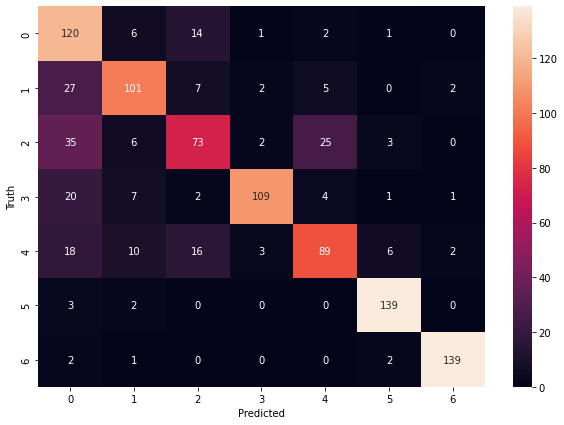

In [13]:
import seaborn as sn
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_classes)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')